In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(1, parentdir+'/src')
import torch
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import time
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import gym
import pybullet as p
import stage.envs
from stage.tasks.onelink.reaching import OneLinkReaching
from stage.utils.nn import use_gpu
use_gpu()

In [4]:
savepath = parentdir + '/data/onelink/'

In [5]:
task = OneLinkReaching(render=False)

# Read task parameters, should we use a separate class to wrap this?

nx, nq, nv, nu = task.nx, task.nq, task.nv, task.nu
dt_control, dt_env = task.dt_control, task.dt_env
q_lb, q_ub = task.q_lb, task.q_ub

In [6]:
# Setup action parameterization

from stage.controllers.actor import Actor
from stage.controllers.trivial import Identity
from stage.controllers.pd import PD
from stage.controllers.mlp import MLP

# action_ub = torch.Tensor(task.env.action_space.high)
# action_lb = torch.Tensor(task.env.action_space.low)
# actor = Actor(na, Identity(nx, nq, nv, nu), action_lb, action_ub)

gain_ub = 50 * torch.ones((nq))
gain_lb = 0. * torch.ones((nq))
action_ub = torch.cat((gain_ub, q_ub))
action_lb = torch.cat((gain_lb, q_lb))
actor = Actor(PD(nx, nq, nv, nu), action_lb, action_ub)
na = actor.na

# actor = Actor(MLP(nx, nq, nv, nu))
# na = actor.na
# actor.action_lb, actor.action_ub = -torch.ones(na), torch.ones(na)

task.cost.actor = actor 

In [7]:
# Setup model learning

from stage.dynamics.probabilistic_ensemble import ProbabilisticEnsemble, DefaultDx

ensemble_size = 5
nn_epochs = 10
batch_size = 64
    
dynamics = ProbabilisticEnsemble(nx, nq, nv, na, dt_control, 
                                 DefaultDx,
                                 ensemble_size, 
                                 learning_rate = 0.001)

In [8]:
# Setup controller

from stage.controllers.pets import PETS

plan_horizon = 30
n_particles = 10
pop_size = 400
assert n_particles % ensemble_size == 0

controller = PETS(dynamics, task.cost, actor,
                  plan_horizon, n_particles, pop_size)

In [9]:
# Setup learner

from stage.learners.learn_and_control_model import LearnAndControlModel
learner = LearnAndControlModel(task, dynamics, controller)

In [10]:
controller.regularize(0)
_ = learner.learn(10, verbose=True)
learner.save_training_data(savepath+'data_pd_reg')

Network training: 100%|██████████| 10/10 [00:00<00:00, 30.72epoch(s)/s, Training loss MSE=0.0009178632]


Iteration:  0
Initial state:  tensor([1.5708, 0.0000])
avg. decision time:  0.005282340049743653
obs. reward:  -228.72165
act. reward:  -0.0004761278


Network training: 100%|██████████| 10/10 [00:00<00:00, 10.88epoch(s)/s, Training loss MSE=0.0053144475]


Iteration:  1
Initial state:  tensor([1.5708, 0.0000])
avg. decision time:  0.15722499132156373
obs. reward:  -277.70322
act. reward:  -0.00010741178


Network training: 100%|██████████| 10/10 [00:01<00:00,  7.46epoch(s)/s, Training loss MSE=0.0032334113]


Iteration:  2
Initial state:  tensor([1.5708, 0.0000])
avg. decision time:  0.15867835998535157
obs. reward:  -233.38788
act. reward:  -0.00010795538


Network training: 100%|██████████| 10/10 [00:01<00:00,  6.17epoch(s)/s, Training loss MSE=0.00047031528]


Iteration:  3
Initial state:  tensor([1.5708, 0.0000])
avg. decision time:  0.15766765832901
obs. reward:  -232.31067
act. reward:  -4.6137207e-05


Network training: 100%|██████████| 10/10 [00:01<00:00,  5.06epoch(s)/s, Training loss MSE=8.01633e-05] 


Iteration:  4
Initial state:  tensor([1.5708, 0.0000])
avg. decision time:  0.1592770004272461
obs. reward:  -253.2622
act. reward:  -7.6264354e-05


Network training: 100%|██████████| 10/10 [00:02<00:00,  4.23epoch(s)/s, Training loss MSE=7.680491e-05]


Iteration:  5
Initial state:  tensor([1.5708, 0.0000])
avg. decision time:  0.15922395944595336
obs. reward:  -137.56006
act. reward:  -0.00042804246


Network training: 100%|██████████| 10/10 [00:02<00:00,  3.67epoch(s)/s, Training loss MSE=5.910841e-05]


Iteration:  6
Initial state:  tensor([1.5708, 0.0000])
avg. decision time:  0.15939234733581542
obs. reward:  -133.33708
act. reward:  -0.0005128687


Network training: 100%|██████████| 10/10 [00:02<00:00,  3.66epoch(s)/s, Training loss MSE=7.622252e-05]


Iteration:  7
Initial state:  tensor([1.5708, 0.0000])
avg. decision time:  0.15979021549224853
obs. reward:  -149.28407
act. reward:  -0.00023124013


Network training: 100%|██████████| 10/10 [00:03<00:00,  2.76epoch(s)/s, Training loss MSE=5.2716423e-05]


Iteration:  8
Initial state:  tensor([1.5708, 0.0000])
avg. decision time:  0.158820059299469
obs. reward:  -100.694984
act. reward:  -0.0011549458


Network training: 100%|██████████| 10/10 [00:03<00:00,  2.56epoch(s)/s, Training loss MSE=7.366042e-05]

Iteration:  9
Initial state:  tensor([1.5708, 0.0000])
avg. decision time:  0.16228952407836914
obs. reward:  -117.91503
act. reward:  -0.0008454842


In [11]:
controller.regularize(0)
traj, log = task.perform(task.goal, controller)
act_seq = traj[:, nx:nx+na]
initial_obs = traj[0, :nx]
final_obs = traj[-1, :nx]

avg. decision time:  0.1616082549095154
obs. reward:  -6559.362
act. reward:  -16.720232


In [12]:
n_sample = 50
traj_pred = dynamics.unroll(initial_obs, 
                            act_seq, 
                            n_sample)
if n_sample > 0:
    predicted_err = torch.norm(traj_pred[-1, :, :]-final_obs.expand(n_sample, -1), p=2, dim=1)
    print (predicted_err.mean())
    print (predicted_err.std())
else:
    predicted_err = torch.norm(traj_pred[-1, :, :]-final_obs, p=2, dim=1)
    print (predicted_err)

tensor(93.1496, grad_fn=<MeanBackward0>)
tensor(1.1697, grad_fn=<StdBackward0>)


In [13]:
task_horizon = task.task_horizon

traj_pred_mean = torch.mean(traj_pred, dim=1)
traj_pred_std = torch.std(traj_pred, dim=1)
traj_pred_mean = traj_pred_mean.detach().cpu().numpy()
traj_pred_std = traj_pred_std.detach().cpu().numpy()
traj = traj.detach().cpu().numpy()

desired = task.cost.desired.repeat((task_horizon, 1))
desired = desired.detach().cpu().numpy()

In [14]:
font = {'family' : 'serif',
        'size'   : 22}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3, linewidth=200, suppress=True)

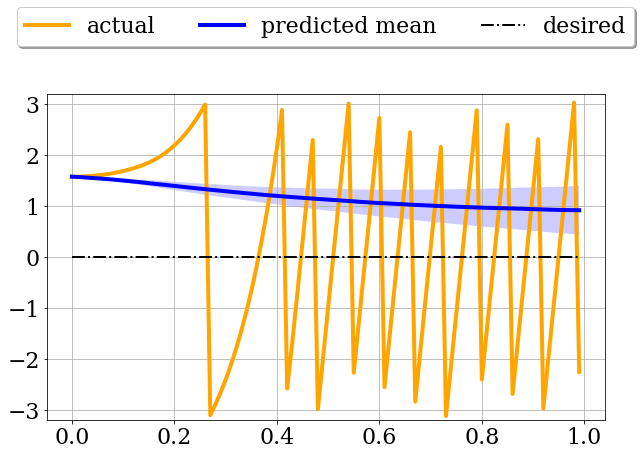

In [15]:
d = nq
dt = dt_control
fig, ax = plt.subplots(d, figsize=(10, d * 6))
t = np.arange(0.0, task_horizon*dt, dt)
dlb = traj_pred_mean - traj_pred_std
ub = traj_pred_mean + traj_pred_std

for i in range(d):
    ax.plot(t, traj[:, i], lw=4, color='orange', label='actual')
    ax.plot(t, traj_pred_mean[:, i], lw=4, color='b', label='predicted mean')
    ax.plot(t, desired[:, i], lw=2, color='k', ls='-.', label='desired')
    lb = traj_pred_mean - traj_pred_std
    ub = traj_pred_mean + traj_pred_std
    ax.fill_between(t, lb[:, i], ub[:, i], facecolor='blue',
                alpha=0.2)
    _ = ax.grid()
    _ = ax.set_ylim([-3.2, 3.2])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
             ncol=3, fancybox=True, shadow=True)
# fig.savefig('prediction_with_reg_150steps' + '.png', bbox_inches='tight')